- Se pravat 2 grafovi: prviot e so blok dijagonalna matrica na sosedstvo, reprezentira familii, vtoriot e vakov LFR_benchmark graf kade site nodes koi pripagjaat vo "community" na daden node ke se smetaat za pobliski prijateli, dodeka site ostanati vrski se smetaat za podalecni prijateli
- Vo familija ke ima najgolema shansa za zarazlivost, megju bliski prijateli pomala, megju podalecni najmala
- Moze da se poigra so "siva masa" kade so mnogu mal procent lugeto se zarazuvaat od nepoznat izvor (bez kontakt so drug covek)
- Da se definira distribucija na denovi za od exposed da se premine vo infected i od infected vo recovered
- Da se definira razlika pomegju exposed i infected node pri zarazuvanje na sosednite nodes (primer exposed gi zarazuva site, no infected zarazuva samo clenovi na familija, bidejki e izoliran)
- Mozebi da se napravi SEIRS model, bidejki lice koe ja prelezalo bolesta gi ima antitelata odredeno vreme, a potoa povtorno moze da se zarazi
- Dinamicka promena na gledanje so prijateli i ostanati vrski (primer na pocetok ne se pocituvaat merki i se gledame so niv sekoj den, koga ke stigne brojot na infected nad odreden threshold se voveduvaat odredeni merki, no tie ne mozat da traat predolgo radi ekonomski pricini, pa se olabavuvaat po odreden period itn.)
***

- Currently,  there  is  no  clear  evidence  that  COVID-19  asymptomatic  persons  can  transmit  SARS-CoV-2,  but  there  is  accumulating  evidence  indicating  that  a  sub-stantial fraction of SARS-CoV-2 infected individuals are asymptomatic [10-12].
- http://med.stanford.edu/content/dam/sm/id/documents/COVID/AsymptCOVID_TransmissionShip.pdf asymp. proportion (P(E->R))
***

In [1]:
import itertools
import networkx as nx
import random as rn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from copy import deepcopy

rn.seed(42)
colors = ["#313695", "#a50026", "#fee838", "#004529"]
status = ["suspectible", "exposed", "infected", "recovered"]

%matplotlib inline

#### To predict the potential severity of outbreaks of infectious diseases such as SARS, HIV, TB and smallpox, a summary parameter,the basic reproduction number R0, is generally calculated from a population-level model. R0specifies the average number ofsecondary infections caused by one infected individual during his/her entire infectious period at the start of an outbreak. R0isused to assess the severity of the outbreak, as well as the strength of the medical and/or behavioral interventions necessary forcontrol. Conventionally, it is assumed that if R0.1 the outbreak generates an epidemic, and if R0,1 the outbreak becomesextinct. 

In [52]:
# Draw from distributions 
t_se = 10.0
t_ei = 7.0
t_ir = 14.0 
t_er = 14.0
t_rs = 60
p_E_to_R = 0.179
R_0_start = 3
k = 2.5
R_0_end = 0.9
x0 = 90
gamma = 1.0/t_ir
    
    
def deriv(y, t, beta, N, t_ei, t_ir, t_er, t_rs, p_E_to_R):
    S, E, I, R = y

    dSdt = (R/t_rs) - (S*I*beta(t)/N)
    dEdt = (S*I*beta(t)/N) - (E/t_er)*p_E_to_R - (E/t_ei)*(1-p_E_to_R) 
    dIdt = (E/t_ei)*(1-p_E_to_R)-I/t_ir
    dRdt = I/t_ir - R/t_rs
    return dSdt, dEdt, dIdt, dRdt


def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end


def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    
def derivative(y, t, N, t_se, t_ei, t_ir, t_er, t_rs, p_E_to_R):
    S, E, I, R = y

    dSdt = (R/t_rs) - (S*I/N*t_se)
    dEdt = (S*I/N*t_se) - (E/t_er)*p_E_to_R - (E/t_ei)*(1-p_E_to_R) 
    dIdt = (E/t_ei)*(1-p_E_to_R)-I/t_ir
    dRdt = I/t_ir - R/t_rs
    return dSdt, dEdt, dIdt, dRdt


def calculate_new_states_beta(days=1, exposed_0=5):
    # N = graph_size
    N = 1000
    y0 = N-exposed_0, exposed_0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, N, t_ei, t_ir, t_er, t_rs, p_E_to_R))
    S, E, I, R = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t, S, E, I, R, R_0_over_time


def calculate_new_states(days=1, exposed_0=5):
    # N = graph_size
    N = 1000
    y0 = N-exposed_0, exposed_0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    
    # Draw from distributions 
    t_se = 10.0
    t_ei = 7.0
    t_ir = 14.0 
    t_er = 14.0
    t_rs = 60
    p_E_to_R = 0.179
    
    ret = odeint(derivative, y0, t, args=(N, t_se, t_ei, t_ir, t_er, t_rs, p_E_to_R))
    S, E, I, R = ret.T

    return S, E, I, R


def decision(probability):
    return rn.random() < probability


def plot_seir(sus, exp, inf, rec, num_days):
    fig = plt.figure(figsize=(18,10))
    plt.plot(range(num_days), sus, c=colors[0])
    plt.plot(range(num_days), exp, c=colors[1])
    plt.plot(range(num_days), inf, c=colors[2])
    plt.plot(range(num_days), rec, c=colors[3])
    plt.legend(status)
    plt.title("SEIR graph for simulation that lasted {} days".format(num_days))
    plt.show()


def generate_graph(num_nodes, tau1=2, tau2=5, mu=0.1, max_degree=15, average_degree=5,
                   min_community=6, max_community=30):
    G = nx.LFR_benchmark_graph(num_nodes, tau1, tau2, mu, average_degree, max_degree=max_degree,
                               min_community=min_community, max_community=max_community, seed=42)
    nx.set_node_attributes(G, 0, "status")
    nx.set_node_attributes(G, -1, "asymp")
    return add_families_to_graph(G, num_nodes)


def add_families_to_graph(F, num_population):
    # Used 2019 USA demographics to get these numbers
    num_family_members = [1, 2, 3, 4, 5, 6, 7]
    probabilities = [0.2837, 0.3451, 0.1507, 0.1276, 0.0578, 0.0226, 0.0125] 
    families = rn.choices(num_family_members, probabilities, k=num_population//2)
    n, i = 0, 0
    while n < num_population:
        if n + families[i] > num_population:
            k = num_population - n
        else:
            k = families[i]
        fam = [x for x in range(n, n+k)]
        edges = itertools.combinations(fam,2)
        F.add_edges_from(edges)
        for j in range(k):
            F.nodes[n+j]['family'] = fam
        n = n+k
        i = i+1
    return F


def plot_graph(G):
    fig, ax = plt.subplots(figsize=(18,10))
    node_color = [colors[x] for x in nx.get_node_attributes(G, "status").values()]
    pos = nx.spring_layout(G)
    for i in range(len(status)):
        node_subset = [x for x, y in G.nodes(data=True) if y["status"]==i]
        nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=node_subset, node_size=100,
                               node_color=colors[i], label=status[i], alpha=.75)
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#a2a2a2", alpha=.75)
    plt.legend()
    
    
def run_simulation(G, num_days, initial_exposed, plot=False, families=False):
    Graph = deepcopy(G)
    num_nodes = len(G.nodes)
    sus = []
    exposed = rn.sample(range(0, num_nodes-1), initial_exposed)
    for i in range(num_nodes):
        if i not in exposed:
            sus.append(i)
            Graph.nodes[i]["status"] = 0
            Graph.nodes[i]["asymp"] = -1
    infected = []
    recovered = []
    
    for i in exposed:
        Graph.nodes[i]["status"] = 1
        Graph.nodes[i]["asymp"] = -1
    
    S = [num_nodes - initial_exposed]
    E = [initial_exposed]
    I = [0]
    R = [0]
    
    # Draw from distributions 
    beta = 3
    t_ei = 7.0
    t_ir = 14.0 
    t_er = 14.0
    t_rs = 60.0
    comm_talk_freq = 3.0
    other_talk_freq = 10.0
    p_E_to_R = 0.179
    
    status = {"sus":0, "exp":1, "inf":2, "rec":3}
    
    for i in range(num_days):
        for j in range(num_nodes):
            # recovered to susceptible 
            # A recovered person can only transition to susceptible. Average transition period is 60 days, so the
            # probability that a random recovered person transitions to a susceptible is 1/60. Distribution later
            sus_now = False
            if Graph.nodes[j]["status"] == status["rec"]:
                p_r_to_s = 1.0/t_rs
                choice = decision(p_r_to_s)
                if choice == True:
                    Graph.nodes[j]["status"] = status["sus"]
                    recovered.remove(j)
                    sus.append(j)
                    sus_now = True
            # susceptible to exposed
            # A susceptible person can only transition to exposed. Factors which affect this transition are the rate of
            # contact, beta = β (“beta”), the expected amount of people an infected person infects per day and the number
            # of contacts. The beta can be used to derive the probability that a random individiual will get infected 
            # when contacting an infected person. This probability = beta/N^ where N^ is equal to the average 
            # number of contacts the infected person sees per day (or his rate of contact). This means that the total
            # probability of transition is 1 - product_i:infected_neighbors(1-beta/N^_i). (1-beta/N^_i) is the probability
            # that infected person i which you are in contact with and see doesn't infect you. The product means is the 
            # probability that no one of the infected people you meet that day infects you. 1-this is the probability that
            # at least one of them infects you. We need to integrate here knowledge about whether the contacts are in a 
            # family, in a community or other contacts in order to see the rate of communication between the target node 
            # and them. So, out of all infected neighbors of node j, we always take into account family members, we take
            # into account community members every 3 days (1/3 chance that j will see a community friend) and every other
            # contact we see every 10 days(1/3 chance that j will see something else(not in community nor family)). The chance
            # to see a community person who is infected is 1/3 * number of infected community neighbors/all neighbors. Same as
            # other members. We use this to derive the final formula : 1-[(1-beta/N_1..*)^family_count)*
            # (1-beta/N_1..* + freq_community-1/freq_community)^community_count * (1-beta/N_1..* + freq_other-1/freq_other)^other_count
            exp_now = False
            if Graph.nodes[j]["status"] == status["sus"] and not sus_now:
                if not exp_now:
                    neighbors = [n for n in Graph.neighbors(j)]
                    total_neighbors = len(neighbors)
                    family = []
                    if families != False:
                        family = [neighbor for neighbor in neighbors if Graph.nodes[neighbor]["family"]==Graph.nodes[j]["family"]]
                    community = [neighbor for neighbor in neighbors if neighbor not in family and 
                                           Graph.nodes[neighbor]["community"]==Graph.nodes[j]["community"]]
                    other = [neighbor for neighbor in neighbors if neighbor not in family and neighbor not in community]
                    community_size = len(community)
                    other_size = len(other)
                    family_size = len(family)
                    multiplier = 1
                    for family_member in family:
                        if Graph.nodes[family_member]["status"] == status["inf"]: # if family infected
                            neighbor_count = len([n for n in Graph.neighbors(family_member)])
                            multiplier*=(1-beta/neighbor_count)
                    for community_member in community:
                        if Graph.nodes[community_member]["status"] == status["inf"]: # if community infected
                            neighbor_count = len([n for n in Graph.neighbors(community_member)])
                            multiplier*=(1-beta/(neighbor_count*comm_talk_freq))
                            # derived
                    for other_member in other:
                        if Graph.nodes[other_member]["status"] == status["inf"]: # if community infected
                            neighbor_count = len([n for n in Graph.neighbors(other_member)])
                            multiplier*=(1-beta/(neighbor_count*other_talk_freq))

                    probability_of_infection = 1-multiplier
                    choice = decision(probability_of_infection)
                    if choice == True:
                        Graph.nodes[j]["status"] = status["exp"]
                        sus.remove(j)
                        exposed.append(j)
                        exp_now = True
            # exposed to infected/recovered
            # An exposed person can either become infected(infectious) in t_ei days or become asympt in t_er days. The
            # probability an exposed person becomes asympt at day 1 of exposure is p_E_to_R (decided at day 1 for 
            # every person - the next day after exposure/ during this day the person can't infect anyone). This means
            # that for every node we first have to decide whether or not the exposed node will be asympt or not. If it
            # is then, the probability of transitioning to recovered is 1/t_er. If it isn't, the probability of transitioning
            # to infected is 1/t_ei.
            inf_now = False
            if Graph.nodes[j]["status"] == status["exp"] and not exp_now:
                if Graph.nodes[j]["asymp"]!=-1: # This means we have already decided whether or not the person is asympt.
                    if Graph.nodes[j]["asymp"] == 1: # asympt
                        choice = decision(1.0/t_er)
                        if choice == True:
                            Graph.nodes[j]["status"] = status["rec"]
                            exposed.remove(j)
                            recovered.append(j)
                    else: # not asympt
                        choice = decision(1.0/t_ei)
                        if choice == True:
                            Graph.nodes[j]["status"] = status["inf"]
                            exposed.remove(j)
                            infected.append(j)
                            inf_now = True
                else: # Haven't decided
                    choice = decision(p_E_to_R) # Deciding asympt
                    if choice == True:
                        Graph.nodes[j]["asymp"] = 1 # asympt
                        choice = decision(1.0/t_er)
                        if choice == True:
                            Graph.nodes[j]["status"] = status["rec"]
                            exposed.remove(j)
                            recovered.append(j)
                    else: # not asympt
                        Graph.nodes[j]["asymp"] = 0
                        choice = decision(1.0/t_ei)
                        if choice == True:
                            Graph.nodes[j]["status"] = status["inf"]
                            exposed.remove(j)
                            infected.append(j)
                            inf_now = True
            # infected to recovered
            # An infected person can only recover. An infected person recovers after t_ir days
            if Graph.nodes[j]["status"] == status["inf"] and not inf_now:
                p_i_to_r = 1.0/t_ir
                choice = decision(p_i_to_r)
                if choice == True:
                    Graph.nodes[j]["status"] = status["rec"]
                    infected.remove(j)
                    recovered.append(j)
                    
        # Finally appending the values for S,E,I,R after day i
        S.append(num_nodes - len(exposed) - len(infected) - len(recovered))
        E.append(len(exposed))
        I.append(len(infected))
        R.append(len(recovered))
        
    plot_seir(S, E, I, R, num_days + 1)
    if plot:
        plot_graph(Graph)

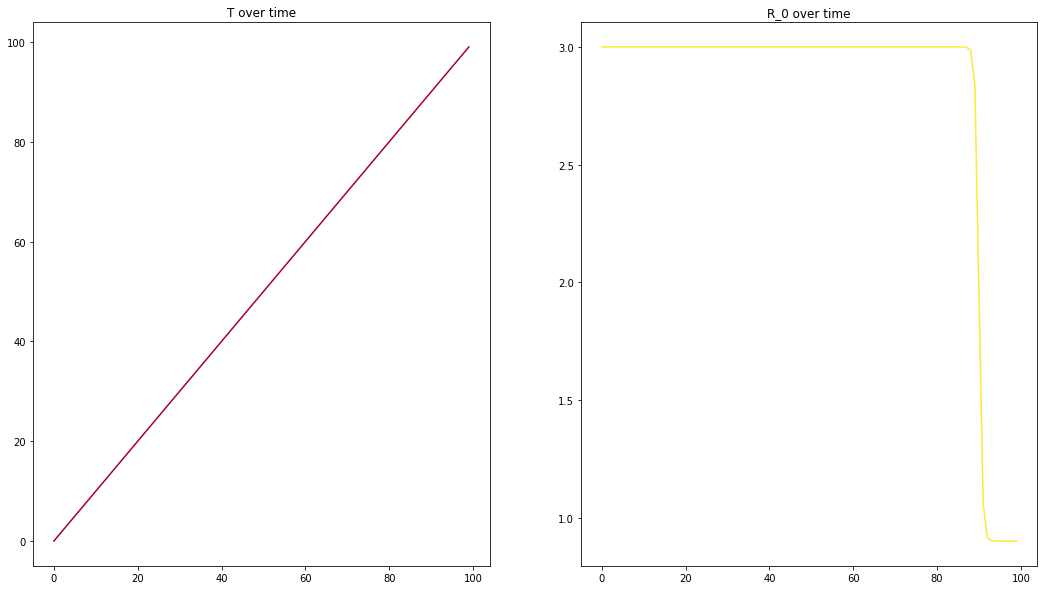

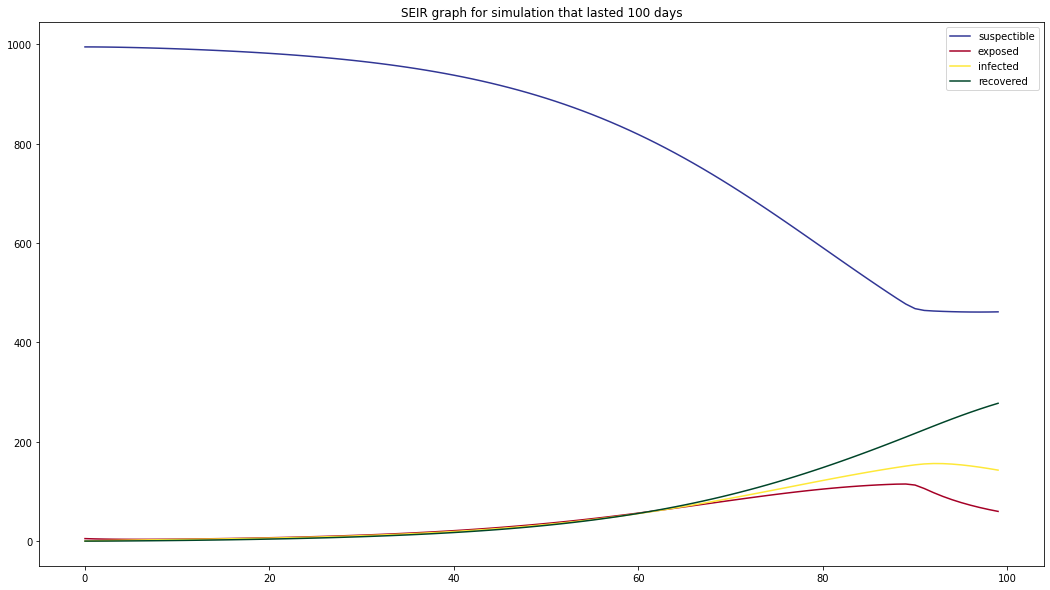

In [29]:
# With beta
days = 100
res_100 = calculate_new_states_beta(days = days)
t = res_100[0]
R_0_over_time = res_100[-1]
fig = plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.plot(range(days), t, c=colors[1])
plt.title("T over time")
plt.subplot(1,2,2)
plt.plot(range(days), R_0_over_time, c=colors[2])
plt.title("R_0 over time")
plt.show()
plot_seir(res_100[1],res_100[2],res_100[3],res_100[4],days)

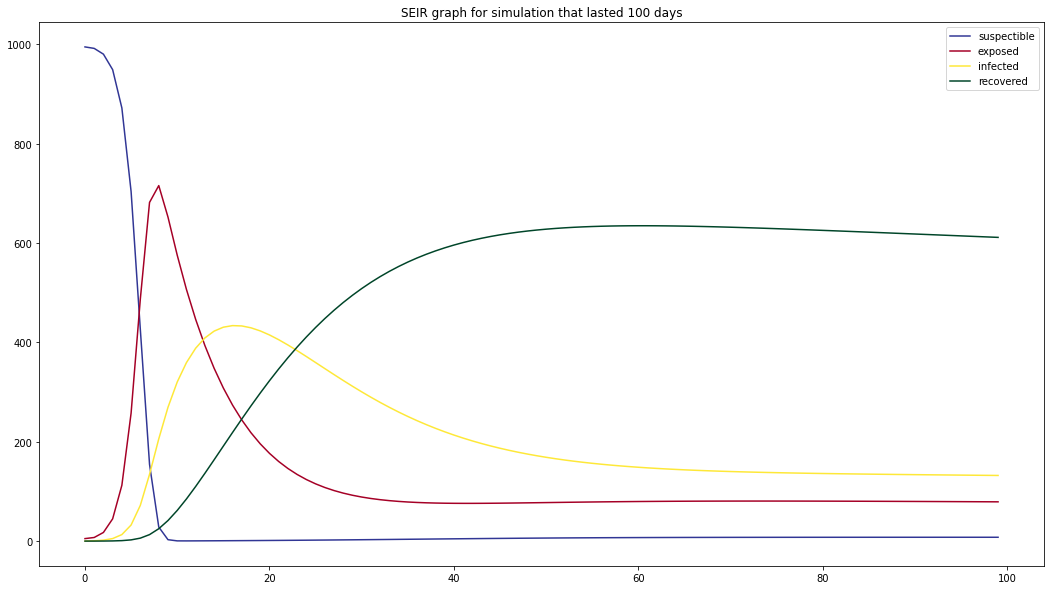

In [30]:
# No beta
days = 100
res_100 = calculate_new_states(days = days)
plot_seir(res_100[0],res_100[1],res_100[2],res_100[3],days)

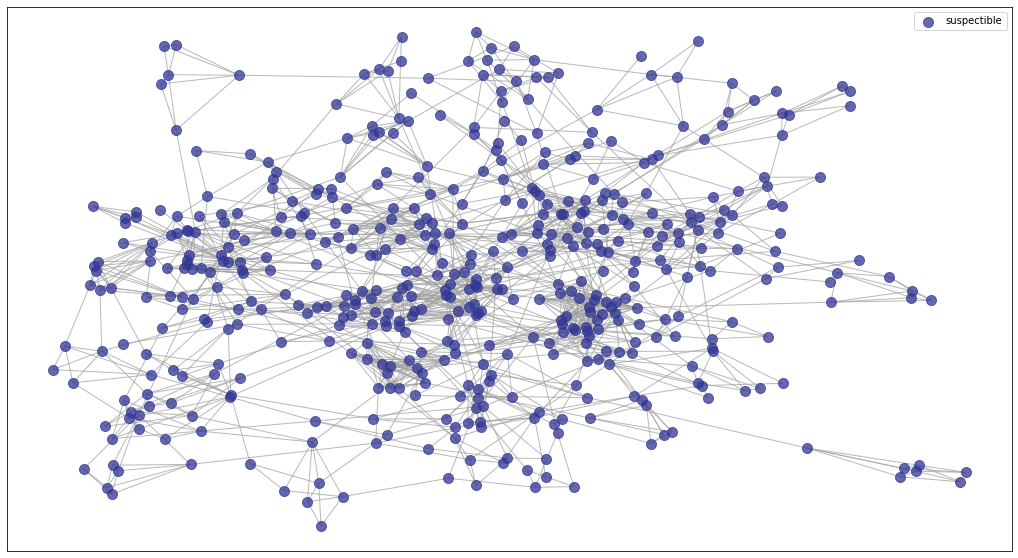

In [53]:
num_nodes = 501
G = nx.LFR_benchmark_graph(num_nodes, 2, 5, 0.1, max_degree=15, average_degree=5,
                           min_community=6, max_community=30, seed=42)
nx.set_node_attributes(G, 0, "status")
nx.set_node_attributes(G, 0, "days")
plot_graph(G)

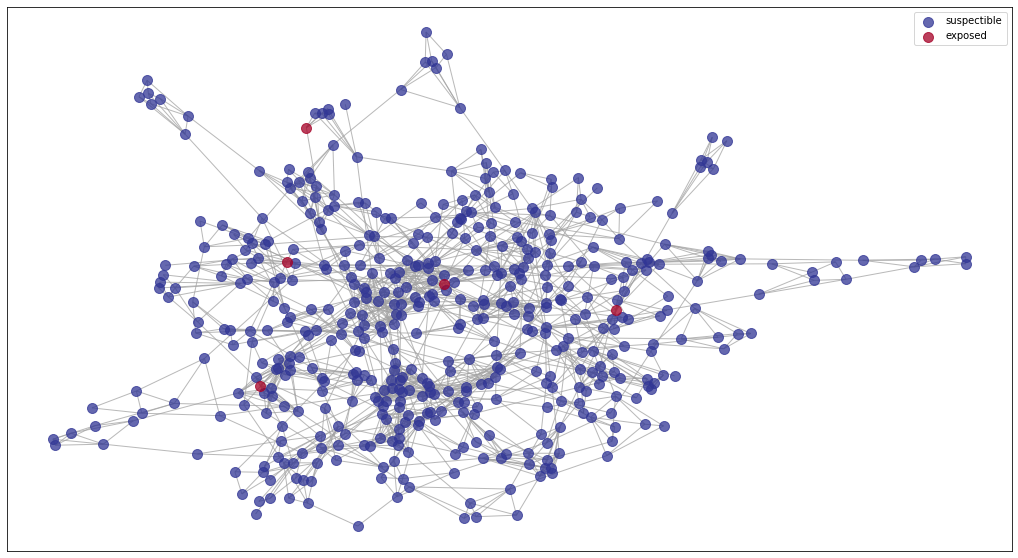

In [54]:
initial_exposed = 5
exposed = [rn.randint(0, num_nodes-1) for i in range(initial_exposed)]
infected = []
recovered = []
G_copy = deepcopy(G)
for i in exposed:
    G.nodes[i]["status"] = 1
plot_graph(G)

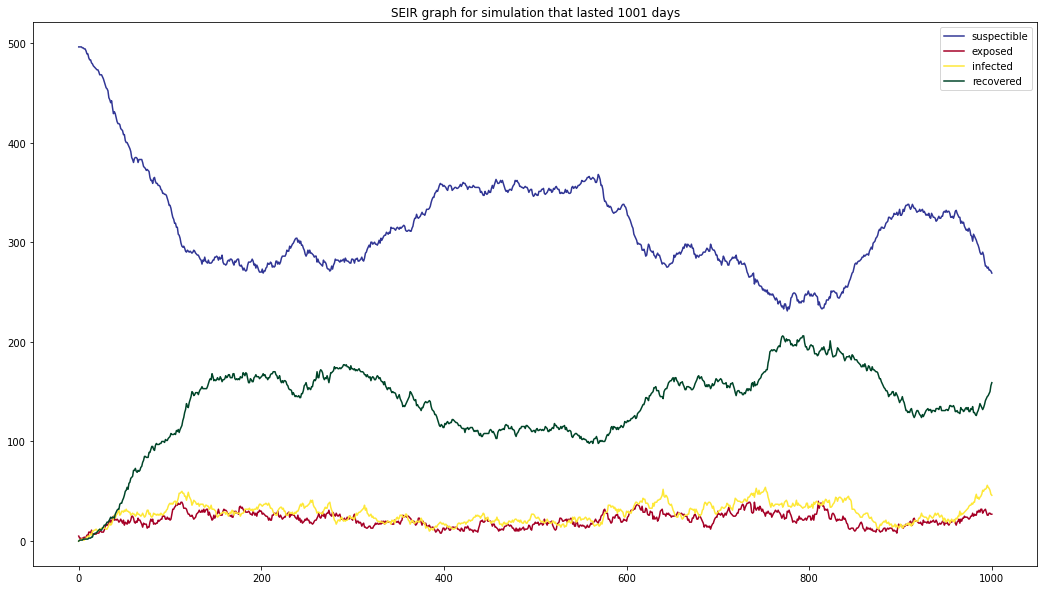

In [56]:
run_simulation(G_copy,1000,initial_exposed,families = False)

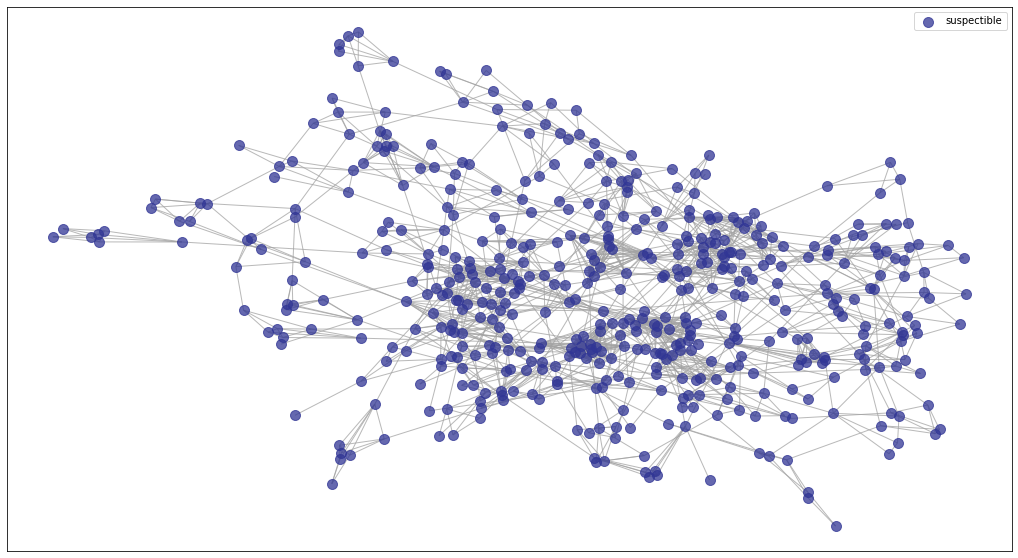

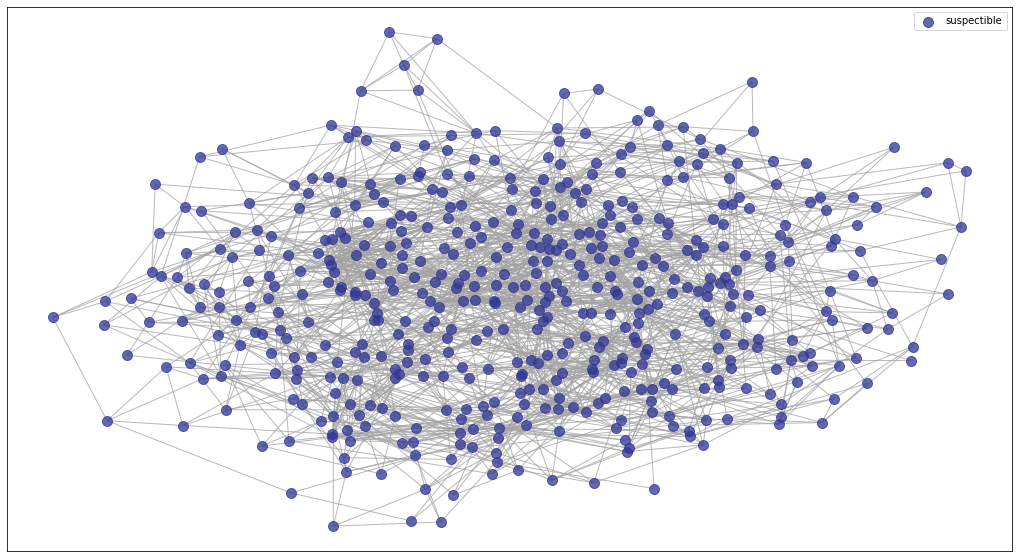

In [57]:
F = add_families_to_graph(deepcopy(G_copy), num_nodes)
plot_graph(G_copy)
plot_graph(F)

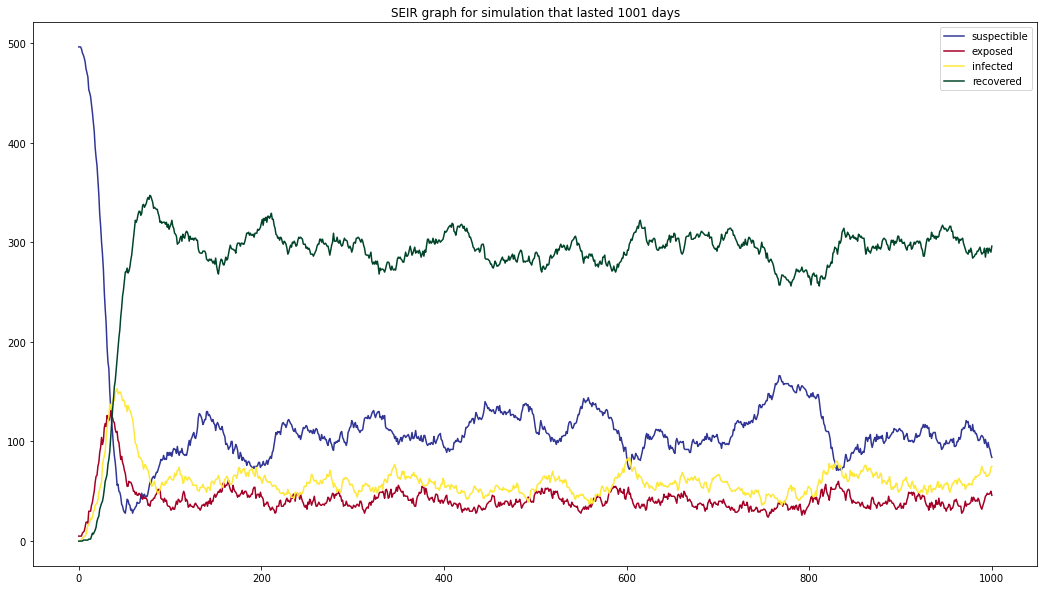

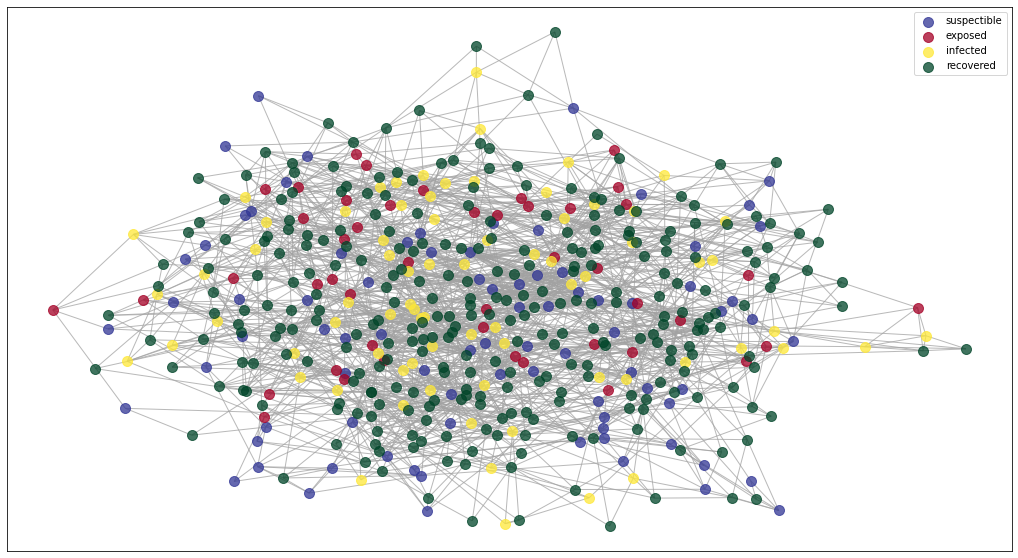

In [58]:
run_simulation(F, num_days=1000, initial_exposed=5, plot=True, families=True)

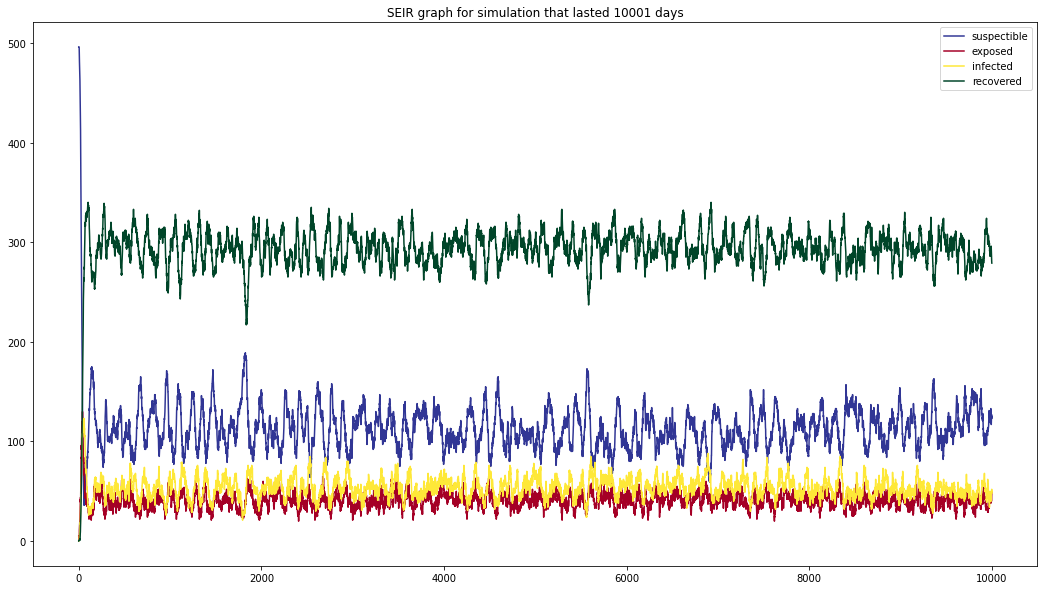

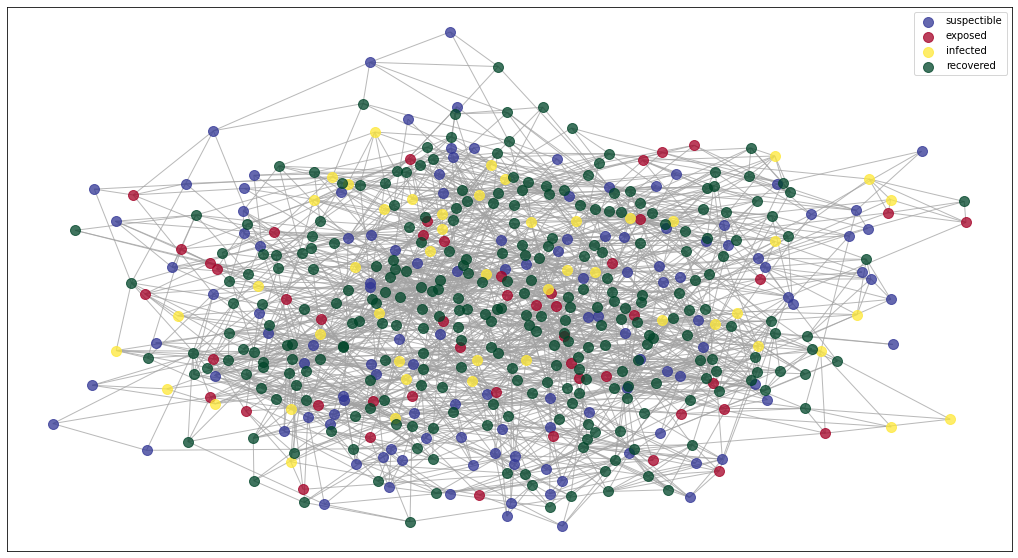

In [59]:
run_simulation(F, num_days=10000, initial_exposed=5, plot=True, families=True)